## Домашнее задание № 7, PyTorch, Кривоногов Н.В.

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


In [43]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [44]:
max_words = 2500
max_len = 25
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [45]:
df = pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv")

In [46]:
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


"label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist"

In [47]:
# наблюдаю сильный дисбаланс классов: 

df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

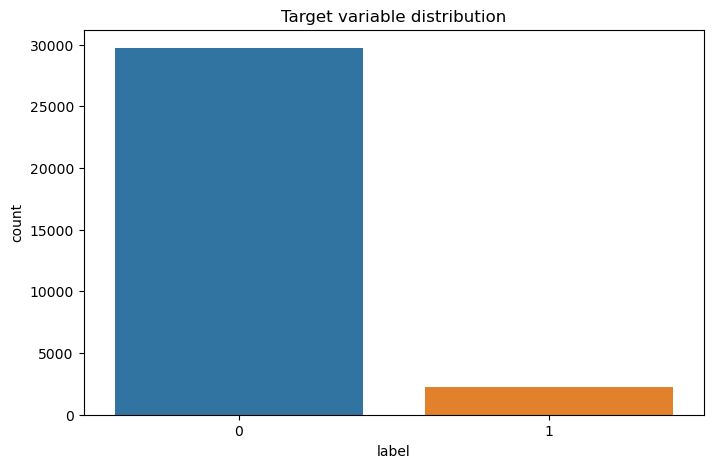

In [48]:
# смотрю распределение целевой переменной label: 

plt.figure(figsize=(8, 5))

sns.countplot(x='label', data=df)

plt.title('Target variable distribution')
plt.show()

In [49]:
# функция балансировки классов: 

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [50]:
# провожу балансировку классов целевой переменной: 

df_for_balancing = df
target_name = 'label'
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

/tmp/ipykernel_269/838415103.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    29720
1    29146
Name: label, dtype: int64

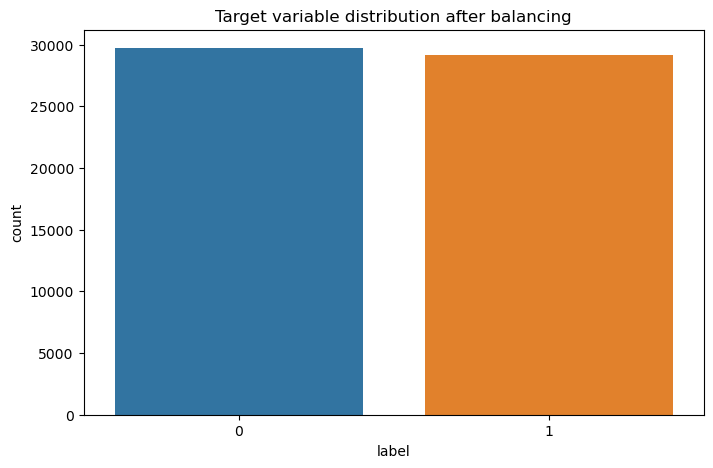

In [51]:
# смотрю распределение целевой переменной после балансировки: 

plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df_balanced)

plt.title('Target variable distribution after balancing')
plt.show()

In [52]:
df_train, df_val = train_test_split(df_balanced, test_size=0.3, random_state=42) #shuffle=True, stratify=df['label'], )

In [53]:
!pip install stop-words pymorphy2

In [54]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [55]:
sw = set(get_stop_words("en"))

sw, len(sw)

({'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  "can't",
  'cannot',
  'could',
  "couldn't",
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'if',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  "let's",
  'me',
  'more',
  'most',
  "mustn't",
  'my',
  'myself',
  'no',
  'nor',
  'not',
  'of',
  'off',
  'on',
  'once',
  'only',
  'or',
  'other',
  'ought',
  'our',
  'ours',
  'ourselves',

In [56]:
new_sw = {'im', 'u', 'us', '2', '2016', '4', '2017', 'ive', '3', '1', 'r', 'iam', 's', 'n', '10', 'ur', 'w', '8', '5', 'd', 'shes', '7', 'b', 'ag', 'bc', '6', 'x', '12', 'gt', 'whos', '1st', 'self', '50', 't', 'y'}

sw = sw.union(new_sw) 

sw, len(sw)

({'1',
  '10',
  '12',
  '1st',
  '2',
  '2016',
  '2017',
  '3',
  '4',
  '5',
  '50',
  '6',
  '7',
  '8',
  'a',
  'about',
  'above',
  'after',
  'ag',
  'again',
  'against',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'b',
  'bc',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  "can't",
  'cannot',
  'could',
  "couldn't",
  'd',
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'gt',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'iam',
  'if',
  'im',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'ive',
  "let's",
  'me',
  'more',
  'm

In [57]:
puncts = set(punctuation)

puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [58]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [59]:
df_train['tweet'].iloc[:1].values

array(['safe travels lads â\x9a½ï¸\x8fð\x9f\x87«ð\x9f\x87· '],
      dtype=object)

In [60]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['safe travels lads â\x9a½ï¸\x8fð\x9f\x87«ð\x9f\x87·'], dtype=object)

In [61]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 17660/17660 [00:06<00:00, 2918.24it/s]


In [62]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [63]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['safe', 'travels', 'lads', 'â\x9a½ï¸\x8fð\x9f\x87', '«']

In [64]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [65]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2499

In [66]:
tokens_filtered_top[:10]

['user',
 'amp',
 'love',
 'trump',
 'like',
 'day',
 'just',
 'will',
 'libtard',
 'people']

In [67]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

vocabulary

{'user': 1,
 'amp': 2,
 'love': 3,
 'trump': 4,
 'like': 5,
 'day': 6,
 'just': 7,
 'will': 8,
 'libtard': 9,
 'people': 10,
 'white': 11,
 'black': 12,
 'happy': 13,
 'new': 14,
 'dont': 15,
 'one': 16,
 'can': 17,
 'time': 18,
 'racist': 19,
 'get': 20,
 'politics': 21,
 'now': 22,
 'cant': 23,
 'life': 24,
 'good': 25,
 'allahsoil': 26,
 'might': 27,
 'today': 28,
 'liberal': 29,
 'women': 30,
 'feel': 31,
 'see': 32,
 'positive': 33,
 'go': 34,
 'sjw': 35,
 'obama': 36,
 'thankful': 37,
 'want': 38,
 'hate': 39,
 'racism': 40,
 'bihday': 41,
 'never': 42,
 'take': 43,
 'via': 44,
 'work': 45,
 'got': 46,
 'need': 47,
 'think': 48,
 'make': 49,
 'great': 50,
 'back': 51,
 'really': 52,
 'world': 53,
 'youre': 54,
 'fathers': 55,
 'listen': 56,
 'thats': 57,
 'retweet': 58,
 'america': 59,
 'man': 60,
 'smile': 61,
 'way': 62,
 'much': 63,
 'right': 64,
 'know': 65,
 'going': 66,
 'first': 67,
 'thanks': 68,
 'stop': 69,
 'girl': 70,
 'fun': 71,
 'healthy': 72,
 'best': 73,
 'still':

In [68]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [69]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 12.5 s, sys: 35.7 ms, total: 12.6 s
Wall time: 12.6 s


In [70]:
x_train.shape

(41206, 25)

In [71]:
df_train['tweet'].iloc[0]

'safe travels lads â\x9a½ï¸\x8fð\x9f\x87«ð\x9f\x87·'

In [72]:
x_train[0]

array([895,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [73]:
from torch.utils.data import DataLoader, Dataset
import torch

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [74]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [75]:
val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [76]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 25])
torch.Size([512])
tensor(0)


In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [78]:
from torch import nn

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [79]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [80]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2500, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 331541


In [81]:
%%time

gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    gru_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    gru_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Epoch [1/5]. Step [81/81]. Loss: 0.410. Acc: 0.681. Test loss: 0.116. Test acc: 0.831
Epoch [2/5]. Step [81/81]. Loss: 0.311. Acc: 0.857. Test loss: 0.336. Test acc: 0.906
Epoch [3/5]. Step [81/81]. Loss: 0.228. Acc: 0.901. Test loss: 0.075. Test acc: 0.927
Epoch [4/5]. Step [81/81]. Loss: 0.215. Acc: 0.919. Test loss: 0.488. Test acc: 0.939
Epoch [5/5]. Step [81/81]. Loss: 0.151. Acc: 0.929. Test loss: 0.043. Test acc: 0.947
Training is finished!
CPU times: user 2min 53s, sys: 353 ms, total: 2min 54s
Wall time: 1min 27s


Архитектура GRU (Gated Recurrent Unit) дала следующие результаты по итогам обучения, которое длилось 1 минуту 27 секунд: 

Epoch [5/5]. Step [81/81]. Loss: 0.151. Acc: 0.929. Test loss: 0.043. Test acc: 0.947

(Для сравнения: результаты обучения модели, презентованной на уроке для аналогичной задачи: 

Epoch [5/5]. Step [355/355]. Loss: 0.525. Acc: 0.712. Test loss: 0.567. Test acc: 0.707)

In [82]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [83]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [84]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2500, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 335381


In [85]:
%%time

lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    lstm_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Epoch [1/5]. Step [81/81]. Loss: 0.434. Acc: 0.671. Test loss: 0.211. Test acc: 0.843
Epoch [2/5]. Step [81/81]. Loss: 0.276. Acc: 0.863. Test loss: 0.166. Test acc: 0.900
Epoch [3/5]. Step [81/81]. Loss: 0.242. Acc: 0.900. Test loss: 0.041. Test acc: 0.925
Epoch [4/5]. Step [81/81]. Loss: 0.217. Acc: 0.917. Test loss: 0.163. Test acc: 0.932
Epoch [5/5]. Step [81/81]. Loss: 0.193. Acc: 0.928. Test loss: 0.273. Test acc: 0.944
Training is finished!
CPU times: user 1min 30s, sys: 8.74 s, total: 1min 39s
Wall time: 49.8 s



Архитектура LSTM (Long Short-Term Memory) дала следующие результаты по итогам обучения, которое длилось почти 50 секунд:

Epoch [5/5]. Step [81/81]. Loss: 0.193. Acc: 0.928. Test loss: 0.273. Test acc: 0.944

(Для сравнения: результаты обучения модели, презентованной на уроке для аналогичной задачи:

Epoch [5/5]. Step [355/355]. Loss: 0.537. Acc: 0.712. Test loss: 0.516. Test acc: 0.709)

Если для данной конкретной задачи сравнивать две архитектуры, то LSTM отработала быстрее, а GRU показала метрику accuracy на тестовой выборке всего лишь на 0.003 выше. 

Вывод: обе архитектуры подходят для решения подобного рода задач. 